# Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import os
from shutil import copyfile

In [3]:
from neuralart.data import *

# Get Data

In [4]:
chan_csv_path = "../raw_data/wikiart/csv_chan"
chan_image_path= "../raw_data/wikiart/dataset_chan"
output_path = "../raw_data/wikiart"
dataset_dir_name = 'dataset'

In [5]:
data_full = get_data(chan_csv_path, chan_image_path, rm_image_duplicate=False)
# save_csv(data_full, output_path, 'data_full.csv')
data_full.shape

(81446, 10)

In [6]:
data = get_data(chan_csv_path, chan_image_path, rm_image_duplicate=True)
# save_csv(data, output_path, 'data.csv')
data.shape

(78748, 10)

In [ ]:
merge_mov1={'name': 'merge_mov1',
            'merging':{'abstract_expressionism': None,
                 'action_painting': None,
                 'analytical_cubism': None,
                 'art_nouveau_modern': 'art_nouveau_modern',
                 'baroque': 'baroque',
                 'color_field_painting': None,
                 'contemporary_realism': None,
                 'cubism': None,
                 'early_renaissance': 'early_renaissance',
                 'expressionism': 'expressionism',
                 'fauvism': None,
                 'high_renaissance': 'high_renaissance',
                 'impressionism': 'impressionism',
                 'mannerism_late_renaissance': 'mannerism_late_renaissance',
                 'minimalism': None,
                 'naive_art_primitivism': 'naive_art_primitivism',
                 'new_realism': None,
                 'northern_renaissance': 'northern_renaissance',
                 'pointillism': None,
                 'pop_art': None,
                 'post_impressionism': 'post_impressionism',
                 'realism': 'realism',
                 'rococo': 'rococo',
                 'romanticism': 'romanticism',
                 'symbolism': 'symbolism',
                 'synthetic_cubism': None,
                 'ukiyo_e': 'ukiyo_e'}}

In [ ]:
merge_test1={'name': 'merge_test1',
            'merging':{'abstract_expressionism': None,
                 'action_painting': None,
                 'analytical_cubism': None,
                 'art_nouveau_modern': None,
                 'baroque': None,
                 'color_field_painting': None,
                 'contemporary_realism': None,
                 'cubism': 'cubism',
                 'early_renaissance': None,
                 'expressionism': None,
                 'fauvism': None,
                 'high_renaissance': None,
                 'impressionism': None,
                 'mannerism_late_renaissance': 'mannerism_late_renaissance',
                 'minimalism': None,
                 'naive_art_primitivism': None,
                 'new_realism': None,
                 'northern_renaissance': None,
                 'pointillism': None,
                 'pop_art': None,
                 'post_impressionism': None,
                 'realism': None,
                 'rococo': None,
                 'romanticism': None,
                 'symbolism': None,
                 'synthetic_cubism': None,
                 'ukiyo_e': 'ukiyo_e'}}

In [ ]:
for n in [100,1000,None]:
    for s in ['drop','max']:
        for k in [False, True]:
            for c in [merge_mov1, None]:
                get_dataset(data, target="movement", class_=c, n=n, strategy=s, 
                            random_state=123, output_path=output_path, keep_genre=k )


In [ ]:
dataset = get_dataset(data, target="movement", class_=merge_test1, random_state=123, keep_genre=True)

In [ ]:
# create_dataset_directory(data_full, chan_image_path, output_path, dataset_dir_name)

# Data Visualization

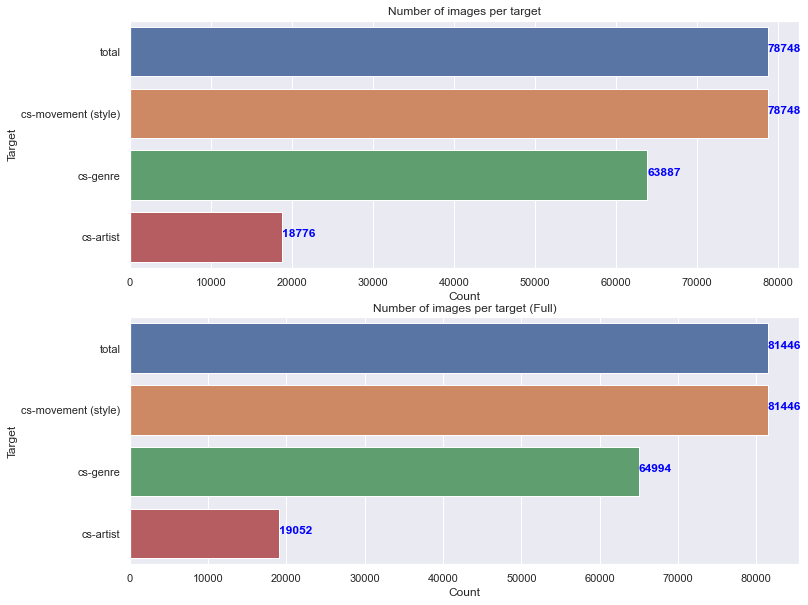

In [7]:
col = ['cs_split_artist','cs_split_genre','cs_split_style','cs_path']

fig, ax = plt.subplots(2,1,figsize=(12,10))
sns.barplot(y=data[col].count().index, 
            x=data[col].count().values,
            order=data[col].count().sort_values(ascending=False).index,
            ax=ax[0]);

for i, v in enumerate(data[col].count().sort_values(ascending=False).values):
    ax[0].text(v, i , str(v), color='blue', fontweight='bold')
    
ax[0].set_yticklabels(['total','cs-movement (style)','cs-genre','cs-artist']);
ax[0].set_title("Number of images per target");
ax[0].set_xlabel("Count");
ax[0].set_ylabel("Target");

sns.barplot(y=data_full[col].count().index, 
            x=data_full[col].count().values,
            order=data[col].count().sort_values(ascending=False).index,
            ax=ax[1]);

for i, v in enumerate(data_full[col].count().sort_values(ascending=False).values):
    ax[1].text(v, i , str(v), color='blue', fontweight='bold')
    
ax[1].set_yticklabels(['total','cs-movement (style)','cs-genre','cs-artist']);
ax[1].set_title("Number of images per target (Full)");
ax[1].set_xlabel("Count");
ax[1].set_ylabel("Target");

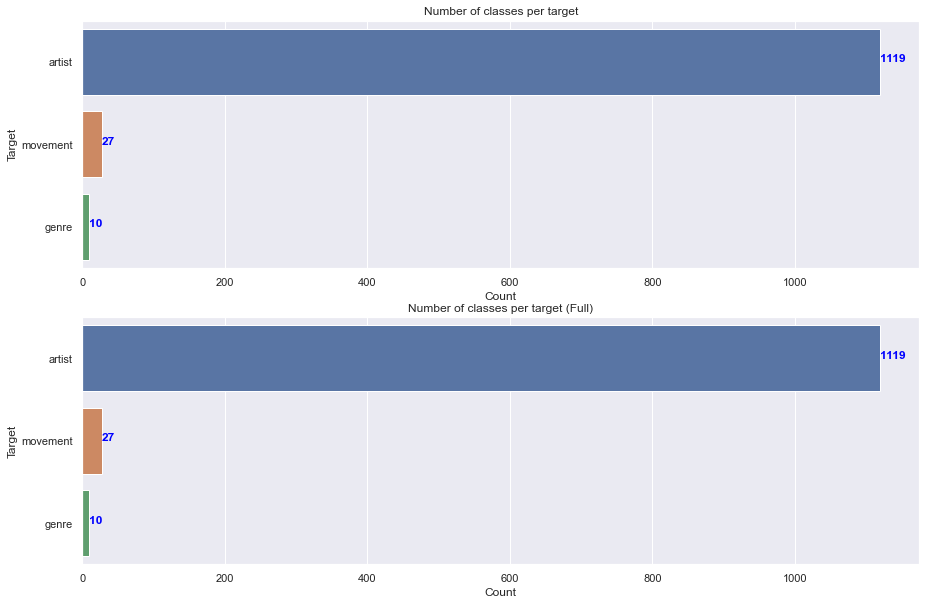

In [10]:
col = ['artist','genre','movement']

fig, ax = plt.subplots(2,1,figsize=(15,10))
sns.barplot(y=data[col].nunique().index, 
            x=data[col].nunique().values,
            order=data[col].nunique().sort_values(ascending=False).index,
            ax=ax[0]);

for i, v in enumerate(data[col].nunique().sort_values(ascending=False).values):
    ax[0].text(v, i , str(v), color='blue', fontweight='bold')
    
ax[0].set_title("Number of classes per target");
ax[0].set_xlabel("Count");
ax[0].set_ylabel("Target");

sns.barplot(y=data_full[col].nunique().index, 
            x=data_full[col].nunique().values,
            order=data_full[col].nunique().sort_values(ascending=False).index,
            ax=ax[1]);

for i, v in enumerate(data_full[col].nunique().sort_values(ascending=False).values):
    ax[1].text(v, i , str(v), color='blue', fontweight='bold')
    
ax[1].set_title("Number of classes per target (Full)");
ax[1].set_xlabel("Count");
ax[1].set_ylabel("Target");

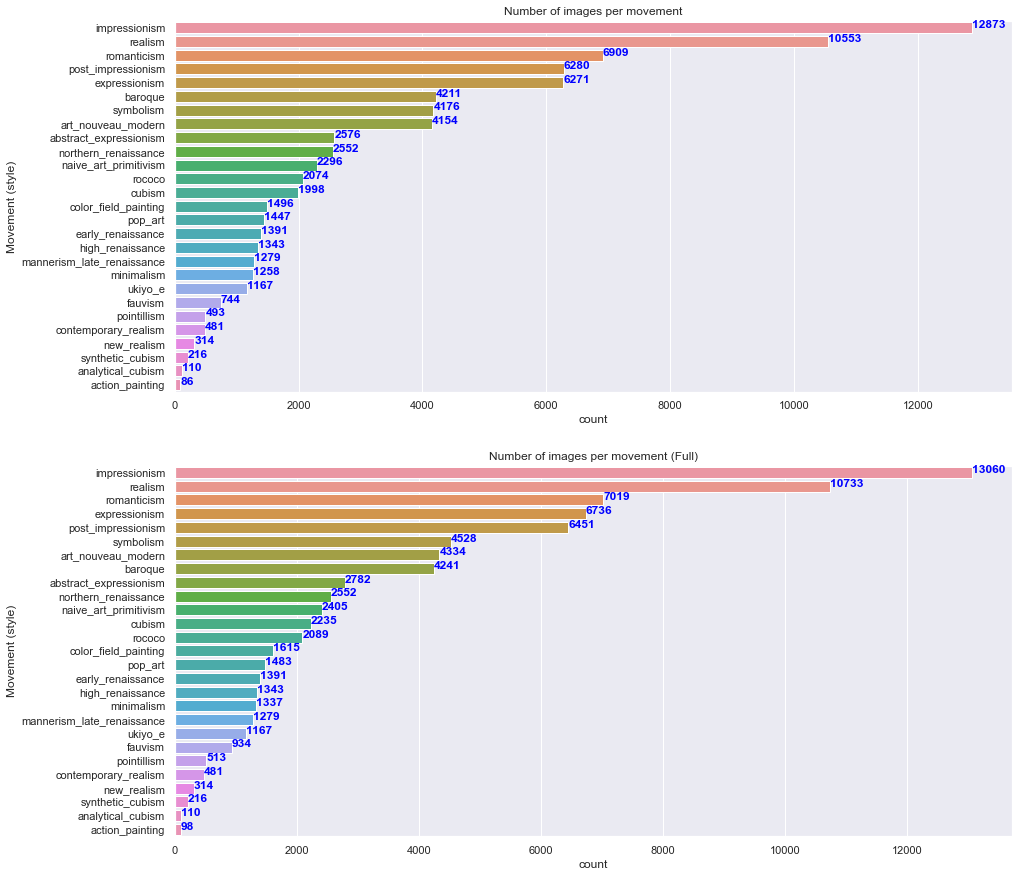

In [14]:
fig, ax = plt.subplots(2,1,figsize=(15,15));
sns.countplot(data=data, y="movement", 
              order = data['movement'].value_counts().index,
              ax=ax[0]);

for i, v in enumerate(data["movement"].value_counts().values):
    ax[0].text(v, i , str(v), color='blue', fontweight='bold')
    
ax[0].set_title("Number of images per movement");
ax[0].set_ylabel("Movement (style)");

sns.countplot(data=data_full, y="movement", 
              order = data_full['movement'].value_counts().index,
              ax=ax[1]);

for i, v in enumerate(data_full["movement"].value_counts().values):
    ax[1].text(v, i , str(v), color='blue', fontweight='bold')
    
ax[1].set_title("Number of images per movement (Full)");
ax[1].set_ylabel("Movement (style)");

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.countplot(data=data, y="genre", 
              order = data['genre'].value_counts().index,
              ax=ax[O]);

for i, v in enumerate(data["genre"].value_counts().values):
    a[0]x.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of images per genre");

sns.countplot(data=data_full, y="genre", 
              order = data_full['genre'].value_counts().index,
              ax=ax[1]);

for i, v in enumerate(data_full["genre"].value_counts().values):
    ax[1].text(v, i , str(v), color='blue', fontweight='bold')
    
ax[1].set_title("Number of images per genre (Full)");

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.barplot(y=data.groupby("movement").artist.nunique().index, 
            x=data.groupby("movement").artist.nunique().values,
            order=data.groupby("movement").artist.nunique().sort_values(ascending=False).index,
            ax=ax);

for i, v in enumerate(data.groupby("movement").artist.nunique().sort_values(ascending=False).values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of artists per movement");
ax.set_xlabel("Count");

In [ ]:
data2 = data[data["cs_split_genre"].notnull()]

fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.countplot(data=data2, y="movement", 
              order = data2['movement'].value_counts().index,
              ax=ax);

for i, v in enumerate(data2["movement"].value_counts().values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of images with genre per movement (style)");
ax.set_ylabel("Movement (style)");